In [0]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, transforms
from skimage.transform import rotate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print(sys.version)
device='cuda'

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
CUDA is available!  Training on GPU ...


In [0]:
df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MNIST/train.csv")
train=df.values
x_train=(train[:,1:]).astype(np.float32)
y_train=(train[:,0])

del df,train

print(x_train.shape)
print(y_train.shape)

(42000, 784)
(42000,)


In [0]:
random_seed = 1
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 7000, random_state = random_seed)

print(x_train.shape)
print(x_train.dtype)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(35000, 784)
float32
(7000, 784)
(35000,)
(7000,)


In [0]:
X_train = []
Y_train = []
np.random.seed(1)
rot_angle = 40*np.random.random_sample([x_train.shape[0],4])
for i in range(x_train.shape[0]):
    X_train.append(x_train[i])
    for j in range(4):
      X_train.append(rotate(x_train[i].reshape((28,28)),angle=rot_angle[i,j],mode='wrap').reshape((784))) 
    for j in range(5):
      Y_train.append(y_train[i])

X_train = np.asarray(X_train,dtype=np.float32)
Y_train = np.asarray(Y_train)
print(X_train.shape)
print(Y_train.shape)

(175000, 784)
(175000,)


7


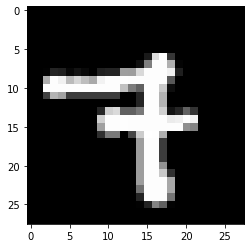

In [0]:
index = 5
print(Y_train[index])
plt.imshow(X_train[index].reshape((28,28)), cmap='gray')

7


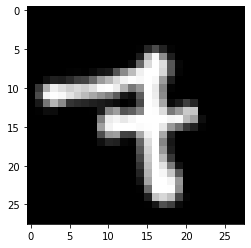

In [0]:
print(Y_train[index+1])
plt.imshow(X_train[index+1].reshape((28,28)), cmap='gray')

In [0]:
X_train = X_train/255.0
x_test = x_test/255.0
final_Xtrain = torch.from_numpy(X_train.reshape(-1,1,28,28)).to(device)
final_Ytrain = torch.from_numpy(Y_train.squeeze()).to(device)

final_Xtest = torch.from_numpy(x_test.reshape(-1,1,28,28)).to(device)
final_Ytest = torch.from_numpy(y_test.squeeze()).to(device)

print(final_Xtrain.size())
print(final_Ytrain.size())
print(final_Xtest.size())
print(final_Ytest.size())

torch.Size([175000, 1, 28, 28])
torch.Size([175000])
torch.Size([7000, 1, 28, 28])
torch.Size([7000])


In [0]:
train_ds = TensorDataset(final_Xtrain,final_Ytrain)
test_ds = TensorDataset(final_Xtest,final_Ytest)

train_dl = DataLoader(train_ds,batch_size=64,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=64,shuffle=True)

In [0]:
class MNIST_CNN(nn.Module):
  def __init__(self):
    super(MNIST_CNN,self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2))
    self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2))
    self.drop1 = nn.Dropout2d(0.4)
    self.lin1 = nn.Linear(7*7*64,128)
    self.norm = nn.BatchNorm1d(128)
    self.drop2 = nn.Dropout(0.4)
    self.lin2 = nn.Linear(128,10)



  def forward(self,xb):
    xb=xb.view(-1,1,28,28)
    xb = self.layer1(xb)
    xb = self.layer2(xb)
    xb = self.drop1(xb)
    xb = torch.flatten(xb,1,3)
    xb = F.relu(self.lin1(xb))
    xb = self.norm(xb)
    xb = self.drop2(xb)
    xb = self.lin2(xb)
    return xb

model = MNIST_CNN()
model.float()
model.to(device)      

MNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1): Dropout2d(p=0.4, inplace=False)
  (lin1): Linear(in_features=3136, out_features=128, bias=True)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (lin2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch No. = 1 cost = 267.1976013183594
Training Accuracy =  0.9713913010359537
Test Accuracy =  0.9861268939393939
Epoch No. = 2 cost = 122.56755065917969
Training Accuracy =  0.9858051492992078
Test Accuracy =  0.9899147727272727
Epoch No. = 3 cost = 95.4149169921875
Training Accuracy =  0.9888368372943327
Test Accuracy =  0.9910511363636364
Epoch No. = 4 cost = 78.2820816040039
Training Accuracy =  0.9907221206581353
Test Accuracy =  0.9914772727272727
Epoch No. = 5 cost = 64.26144409179688
Training Accuracy =  0.9925293266301036
Test Accuracy =  0.9914772727272727
Epoch No. = 6 cost = 57.17283248901367
Training Accuracy =  0.993289152955515
Test Accuracy =  0.9919034090909091
Epoch No. = 7 cost = 50.57075500488281
Training Accuracy =  0.9943041590493601
Test Accuracy =  0.9914772727272727
Epoch No. = 8 cost = 44.61053466796875
Training Accuracy =  0.9946755027422304
Test Accuracy =  0.990909090909091
Epoch No. = 9 cost = 41.945438385009766
Training Accuracy =  0.9948811700182816
Tes

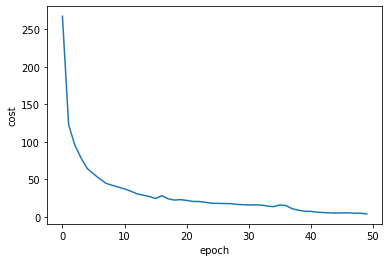

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, eps=1e-09)

epochs = 50
costs = []

for epoch in range(epochs):
  total_loss = 0
  train_acc = 0
  model.train()
  for (x,y) in train_dl:
    x.to(device)
    y.to(device)
    Ypred = model(x.float())
    Ypred.to(device)
    loss = criterion(Ypred,y)
    total_loss = total_loss + loss
    Ypred_binary = torch.argmax(Ypred, keepdim= False, dim=1)
    train_acc = train_acc + accuracy_score(y.cpu(),Ypred_binary.cpu())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  costs.append(total_loss)
  print("Epoch No. = "+ str(epoch+1), "cost = "+str(costs[epoch].item()))
  print("Training Accuracy = ", train_acc/len(train_dl))
  lr_scheduler.step(total_loss/len(train_dl))

  model.eval()
  with torch.no_grad():
    cv_acc = 0
    for x_val,y_val in test_dl:
      x_val.to(device)
      y_val.to(device)
      Ypred_val = model(x_val.float())
      Ypred_val.to(device)
      Ypred_val_binary = torch.argmax(Ypred_val, keepdim= False, dim=1)
      cv_acc = cv_acc + accuracy_score(y_val.cpu(),Ypred_val_binary.cpu())
    print("Test Accuracy = ", cv_acc/len(test_dl))

plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("epoch")
plt.show()      

In [0]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
test_loader = DataLoader(test_ds,batch_size=1,shuffle=True)
model.eval()

CUDA Available:  True


MNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1): Dropout2d(p=0.4, inplace=False)
  (lin1): Linear(in_features=3136, out_features=128, bias=True)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.4, inplace=False)
  (lin2): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [0]:
def test( model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)

        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 6953 / 7000 = 0.9932857142857143
Epsilon: 0.05	Test Accuracy = 6453 / 7000 = 0.9218571428571428
Epsilon: 0.1	Test Accuracy = 4588 / 7000 = 0.6554285714285715
Epsilon: 0.15	Test Accuracy = 2413 / 7000 = 0.3447142857142857
Epsilon: 0.2	Test Accuracy = 1136 / 7000 = 0.16228571428571428
Epsilon: 0.25	Test Accuracy = 669 / 7000 = 0.09557142857142857
Epsilon: 0.3	Test Accuracy = 475 / 7000 = 0.06785714285714285


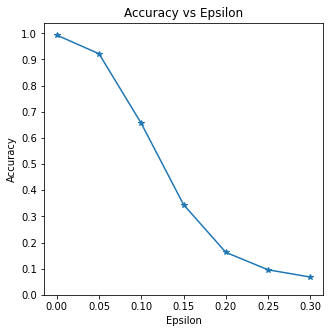

In [0]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

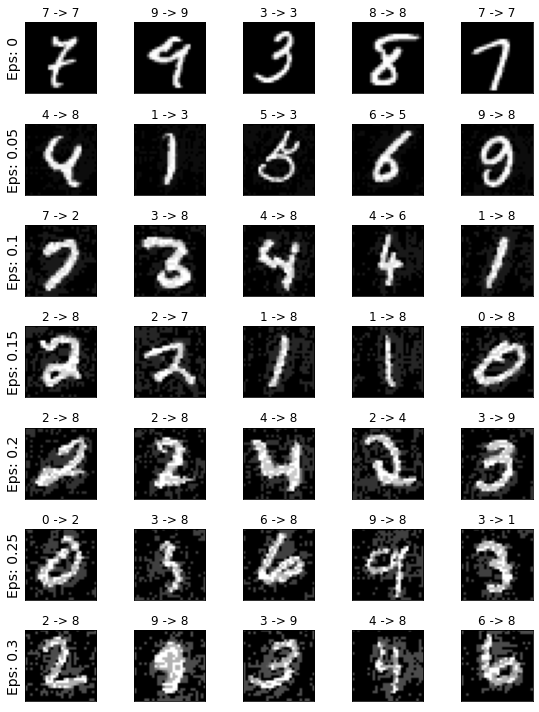

In [0]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [0]:
x_train = x_train/255.0
xtrain = torch.from_numpy(x_train.reshape(-1,1,28,28)).to(device)
ytrain = torch.from_numpy(y_train.squeeze()).to(device)
original_ds = TensorDataset(xtrain,ytrain)
original_dl = DataLoader(original_ds,batch_size=1,shuffle=False)

In [0]:
def perturbed_images(model, device, data_loader, epsilon):

  perturbed_data = []

  for data, target in data_loader:

    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    
    output = model(data)
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_image = fgsm_attack(data, epsilon, data_grad)
    perturbed_ex = perturbed_image.squeeze().detach().cpu().numpy()
    perturbed_data.append(perturbed_ex)

  return perturbed_data  

In [0]:
perturbed_eps1 = perturbed_images(model, device, original_dl, 0.05)
print(len(perturbed_eps1))
print(perturbed_eps1[0].shape)

35000
(28, 28)


In [0]:
for i in range(len(perturbed_eps1)):
  perturbed_eps1[i] = perturbed_eps1[i].reshape((784))

In [0]:
perturbed_eps2 = perturbed_images(model, device, original_dl, 0.1)
for i in range(len(perturbed_eps2)):
  perturbed_eps2[i] = perturbed_eps2[i].reshape((784))

print(perturbed_eps1[0].shape)
print(perturbed_eps2[1].shape)
print(len(perturbed_eps2)) 

(784,)
(784,)
35000


In [0]:
perturbed_eps1 = np.asarray(perturbed_eps1,dtype=np.float32)
perturbed_eps2 = np.asarray(perturbed_eps2,dtype=np.float32)
print(perturbed_eps1.shape)
print(perturbed_eps2.shape)

(35000, 784)
(35000, 784)


In [0]:
new_Xtrain = np.concatenate((perturbed_eps1,perturbed_eps2),axis=0)
new_Ytrain = np.concatenate((y_train,y_train),axis=0)
print(new_Xtrain.shape)
print(new_Ytrain.shape)

(70000, 784)
(70000,)


In [0]:
new_xtrain = torch.from_numpy(new_Xtrain.reshape(-1,1,28,28)).to(device)
new_ytrain = torch.from_numpy(new_Ytrain.squeeze()).to(device)
new_train_ds = TensorDataset(new_xtrain,new_ytrain)
train_loader = DataLoader(new_train_ds,batch_size=64,shuffle=True)  

7


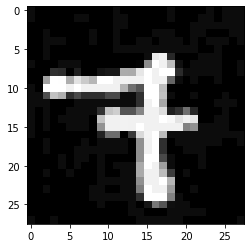

In [0]:
print(new_Ytrain[1])
plt.imshow(new_Xtrain[1].reshape((28,28)), cmap='gray')

7


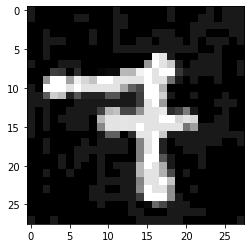

In [0]:
print(new_Ytrain[1+35000])
plt.imshow(new_Xtrain[1+35000].reshape((28,28)), cmap='gray')

Epoch No. = 1 cost = 887.2261352539062
Training Accuracy =  0.8793275822669104
Test Accuracy =  0.9916193181818181
Epoch No. = 2 cost = 648.0170288085938
Training Accuracy =  0.9045837141986593
Epoch    52: reducing learning rate of group 0 to 1.0000e-06.
Test Accuracy =  0.9919034090909091
Epoch No. = 3 cost = 572.5530395507812
Training Accuracy =  0.9122771937842779
Test Accuracy =  0.9914772727272727
Epoch No. = 4 cost = 557.6246337890625
Training Accuracy =  0.9146528412553322
Epoch    54: reducing learning rate of group 0 to 1.0000e-07.
Test Accuracy =  0.9911931818181818
Epoch No. = 5 cost = 549.8146362304688
Training Accuracy =  0.9147909049360147
Test Accuracy =  0.9914772727272727
Epoch No. = 6 cost = 551.3003540039062
Training Accuracy =  0.9138625457038391
Epoch    56: reducing learning rate of group 0 to 1.0000e-08.
Test Accuracy =  0.9917613636363637
Epoch No. = 7 cost = 560.9049682617188
Training Accuracy =  0.9151860527117611
Test Accuracy =  0.9916193181818181
Epoch No.

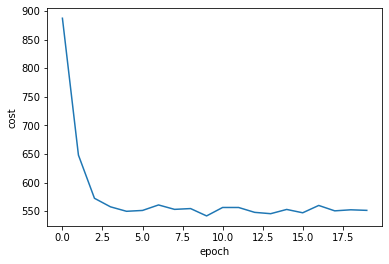

In [0]:
epochs = 20
costs = []

for epoch in range(epochs):
  total_loss = 0
  train_acc = 0
  model.train()
  for (x,y) in train_loader:
    x.to(device)
    y.to(device)
    Ypred = model(x.float())
    Ypred.to(device)
    loss = criterion(Ypred,y)
    total_loss = total_loss + loss
    Ypred_binary = torch.argmax(Ypred, keepdim= False, dim=1)
    train_acc = train_acc + accuracy_score(y.cpu(),Ypred_binary.cpu())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  costs.append(total_loss)
  print("Epoch No. = "+ str(epoch+1), "cost = "+str(costs[epoch].item()))
  print("Training Accuracy = ", train_acc/len(train_loader))
  lr_scheduler.step(total_loss/len(train_loader))

  model.eval()
  with torch.no_grad():
    cv_acc = 0
    for x_val,y_val in test_dl:
      x_val.to(device)
      y_val.to(device)
      Ypred_val = model(x_val.float())
      Ypred_val.to(device)
      Ypred_val_binary = torch.argmax(Ypred_val, keepdim= False, dim=1)
      cv_acc = cv_acc + accuracy_score(y_val.cpu(),Ypred_val_binary.cpu())
    print("Test Accuracy = ", cv_acc/len(test_dl))

plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("epoch")
plt.show()      

In [0]:
new_accuracies = []
new_examples = []

# Run test for each epsilon
for eps in epsilons:
    nacc, nex = test(model, device, test_loader, eps)
    new_accuracies.append(nacc)
    new_examples.append(nex)

Epsilon: 0	Test Accuracy = 6938 / 7000 = 0.9911428571428571
Epsilon: 0.05	Test Accuracy = 6690 / 7000 = 0.9557142857142857
Epsilon: 0.1	Test Accuracy = 6035 / 7000 = 0.8621428571428571
Epsilon: 0.15	Test Accuracy = 4682 / 7000 = 0.6688571428571428
Epsilon: 0.2	Test Accuracy = 2756 / 7000 = 0.39371428571428574
Epsilon: 0.25	Test Accuracy = 1341 / 7000 = 0.19157142857142856
Epsilon: 0.3	Test Accuracy = 661 / 7000 = 0.09442857142857143


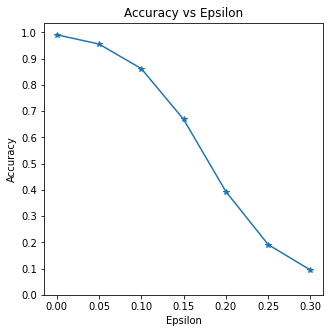

In [0]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, new_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()